# Machine Learning for Stock Clustering using K-Means Algorithm

How you can use clustering to make portfolios more diverse through unsupervised stock clustering?

Diversification is a key step for constructing portfolios but true diversification is not possible as investing in each company requires a lot of capital. Apart from this, not all companies are worth investing in and that may be because they are highly illiquid.

So now what you want to do is come up with an effective strategy where you pick only those stocks that behave differently. This will help in mitigating the risk and one way of doing it is to pick stocks from different sectors but a more data-driven solution can be to apply K-Means clustering algorithm on stock data to identify different clusters of stocks.

Diversification is a key step for constructing portfolios but true diversification is not possible as investing in each company requires a lot of capital. Apart from this, not all companies are worth investing in and that may be because they are highly illiquid.

So now what you want to do is come up with an effective strategy where you pick only those stocks that behave differently. This will help in mitigating the risk and one way of doing it is to pick stocks from different sectors but a more data-driven solution can be to apply K-Means clustering algorithm on stock data to identify different clusters of stocks.

First, we need our data in an organized structure. For this task, I am going to use a list of Shariah Compliant stocks as listed [here](https://www.almeezangroup.com/investor-education/shariah-methodology/). The list has been updated so my selection of companies may be a bit different.

The following code block loads the data from the computer and structures it according to our needs





In [1]:
import  pylab as pl

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np

from scipy.cluster.vq import kmeans,vq
from math import sqrt

from sklearn.cluster import KMeans

import pandas as pd
import pandas_datareader as dr

from matplotlib import pyplot as plt

Download pricing data for the S&P 500 stocks, calculate their historic returns and volatility and then proceed to use the K-Means clustering algorithm to divide the stocks into distinct groups based upon said returns and volatilities.

So why would we want to do this you ask? Well dividing stocks into groups with *similar characteristics* can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification between them.

The concept behind K-Means clustering is explained [here](https://en.wikipedia.org/wiki/K-means_clustering) far more succinctly than I ever could, so please visit that link for more details on the concept and algorithm

First things first, we need to collect the data – lets run our imports and create a simple data download script that scrapes the web to collect the tickers for all the individual stocks within the S&P 500.

<font color=red> Warning</font>: downloading may take a while, especially for large list of constituents. Enjoy Netflix or make a coffee... Alternatively, skip to the next step and uncomment `prices_df=pd.read_csv('SP500.csv')` to read the data from file I saved earlier. 

In [ ]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

#read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)

# get the list of ticker symbols
tickers = data_table[0]['Symbol'].tolist()

# Download prices
prices_list = []
for ticker in tickers:
    try:
        prices = dr.DataReader(ticker,'yahoo','01/01/2017')['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)

prices_df.sort_index(inplace=True)

prices_df.head()

In [13]:
# OPTION 1: Write the data if you just downloaded it (1st line) 
#prices_df.to_csv('SP500.csv')

# OPTION 2: read the data in if you have saved it before
#prices_df=pd.read_csv('SP500.csv')


prices_df.dropna(inplace=True)
prices_df.set_index('Date', inplace=True)
prices_df.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-09,166.476151,108.847244,85.521492,273.559998,227.911179,78.209999,502.160004,83.099998,155.079300,19.052191,...,72.669998,72.231865,19.663063,120.597343,90.077354,94.609108,284.000000,147.751602,31.101215,164.967529
2020-10-12,165.837006,110.236992,86.126091,277.850006,229.804703,81.059998,510.890015,84.290001,156.007858,19.249418,...,74.110001,73.135880,19.930119,118.563118,91.350113,95.094589,288.250000,148.909729,31.347427,168.078812
2020-10-13,163.850693,107.576622,85.648270,276.950012,228.598831,81.980003,514.309998,85.279999,157.136108,19.279003,...,71.739998,72.519958,19.712519,117.585892,89.381317,95.124321,286.730011,144.576721,30.067137,164.857849
2020-10-14,165.591156,107.317657,85.074974,280.839996,228.648651,81.900002,506.309998,84.209999,156.337341,19.357893,...,71.699997,71.874229,19.791647,117.416382,90.306061,95.629601,284.769989,145.485260,29.771683,163.202484
2020-10-15,166.259827,106.889381,84.244690,283.570007,227.990906,80.349998,501.149994,83.129997,157.275894,19.584707,...,72.699997,71.725212,19.900446,117.895020,90.455208,98.572212,287.309998,147.302322,30.697433,162.534363


In [35]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = prices_df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']

returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)

#format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

In [16]:
returns

,Returns,Volatility
MMM,0.233859,0.228599
ABT,0.214818,0.235405
ABBV,0.593489,0.268553
ABMD,0.312870,0.373936
ACN,0.257932,0.245312
...,...,...
YUM,0.269154,0.213532
ZBRA,1.375730,0.350793
ZBH,0.225284,0.316881
ZION,1.650055,0.607898


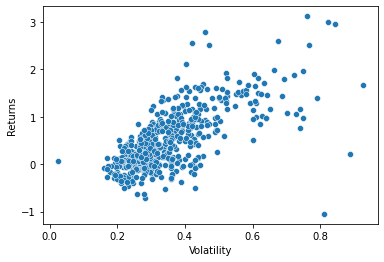

In [17]:
import seaborn as sns
sns.scatterplot(data=returns, x="Volatility", y="Returns");

In [18]:
sharpe = returns.eval("Returns / Volatility").rename("Sharpe")

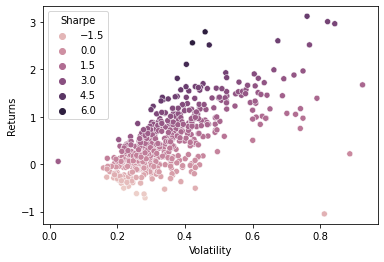

In [19]:
sns.scatterplot(data=returns, x="Volatility", y="Returns", hue=sharpe);

Our first decision is to choose how many clusters do we actually want to separate the data into. Rather than make some arbitrary decision we can use an **Elbow Curve** to highlight the relationship between how many clusters we choose, and the Sum of Squared Errors (SSE) resulting from using that number of clusters.

We then plot this relationship to help us identify the optimal number of clusters to use – we would prefer a lower number of clusters, but also would prefer the SSE to be lower – so this trade off needs to be taken into account.

Lets run the code for our Elbow Curve plot.

In [1]:
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

NameError: name 'data' is not defined

So we can sort of see that once the number of clusters reaches 5 (on the bottom axis), the reduction in the SSE begins to slow down for each increase in cluster number. This would lead me to believe that the optimal number of clusters for this exercise lies around the 5 mark – so let's use 5.

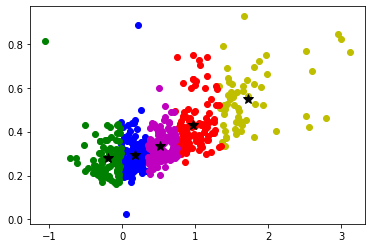

In [30]:
# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(data,5)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

# some plotting using numpy's logical indexing
# (this example was taked from an online tutorial, clearly we would want returns on y-axis and volatility on x-axis)
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plot(centroids[:,0],centroids[:,1],'*k',markersize=10) 
show()

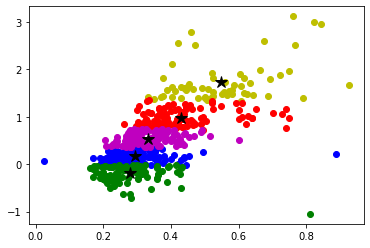

In [31]:
# The example code directly above was taked from an online tutorial, clearly we would want returns on y-axis and volatility on x-axis)
id_Xaxis=1;
id_Yaxis=0;

plot(data[idx==0,id_Xaxis],data[idx==0,id_Yaxis],'ob', # 'ob' means use symbol 'o' (b)lue color, y=yellow, r=red
     data[idx==1,id_Xaxis],data[idx==1,id_Yaxis],'oy', # s=square; *=star, etc....
     data[idx==2,id_Xaxis],data[idx==2,id_Yaxis],'or',
     data[idx==3,id_Xaxis],data[idx==3,id_Yaxis],'og',
     data[idx==4,id_Xaxis],data[idx==4,id_Yaxis],'om')
plot(centroids[:,id_Xaxis],centroids[:,id_Yaxis],'*k',markersize=12) # plot cluster centroids using black stars

show()

Ok, so **now** it is starting to look like an efficient frontier (recall Markowitz portfolio optimization).

But it looks like we have an outlier in the data which is skewing the results and making it difficult to actually see what is going on for all the other stocks. Let’s take the easy route and just delete the outlier from our data set and run this again.

In [32]:
#identify the outliers
print(returns.idxmax())

Returns       MRO
Volatility    CCL
dtype: object


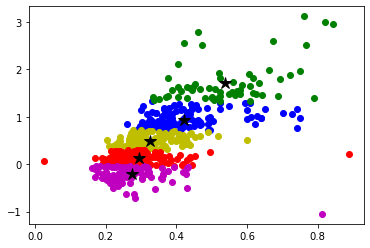

In [36]:
#drop the relevant stock from our data
returns.drop('CCL',inplace=True)

#recreate data to feed into the algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(data,5)
# assign each sample to a cluster
idx,_ = vq(data,centroids)
# some plotting using numpy's logical indexing
id_Xaxis=1;
id_Yaxis=0;
plot(data[idx==0,id_Xaxis],data[idx==0,id_Yaxis],'ob', # 'ob' means use symbol 'o' (b)lue color, y=yellow, r=red
     data[idx==1,id_Xaxis],data[idx==1,id_Yaxis],'oy', # s=square; *=star, etc....
     data[idx==2,id_Xaxis],data[idx==2,id_Yaxis],'or',
     data[idx==3,id_Xaxis],data[idx==3,id_Yaxis],'og',
     data[idx==4,id_Xaxis],data[idx==4,id_Yaxis],'om')
plot(centroids[:,id_Xaxis],centroids[:,id_Yaxis],'*k',markersize=12) # plot cluster centroids using black stars

show()

Finally to get the details of which stock is actually in which cluster we can run the following line of code to carry out a list comprehension to create a list of tuples in the (Stock Name, Cluster Number) format:

In [37]:
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
for detail in details:
    print(detail)

('MMM', 2)
('ABT', 2)
('ABBV', 1)
('ABMD', 1)
('ACN', 2)
('ATVI', 1)
('ADBE', 4)
('AMD', 4)
('AAP', 2)
('AES', 0)
('AFL', 0)
('A', 2)
('APD', 4)
('AKAM', 4)
('ALK', 3)
('ALB', 0)
('ARE', 4)
('ALXN', 1)
('ALGN', 3)
('ALLE', 2)
('LNT', 4)
('ALL', 1)
('GOOGL', 0)
('GOOG', 0)
('MO', 1)
('AMZN', 4)
('AMCR', 2)
('AEE', 4)
('AAL', 0)
('AEP', 4)
('AXP', 0)
('AIG', 0)
('AMT', 4)
('AWK', 4)
('AMP', 0)
('ABC', 2)
('AME', 1)
('AMGN', 4)
('APH', 4)
('ADI', 1)
('ANSS', 4)
('ANTM', 1)
('AON', 1)
('AOS', 2)
('APA', 3)
('AAPL', 2)
('AMAT', 3)
('APTV', 0)
('ADM', 1)
('ANET', 1)
('AJG', 1)
('AIZ', 2)
('T', 2)
('ATO', 4)
('ADSK', 1)
('ADP', 1)
('AZO', 2)
('AVB', 1)
('AVY', 0)
('BKR', 3)
('BLL', 4)
('BAC', 0)
('BK', 1)
('BAX', 2)
('BDX', 2)
('BBY', 4)
('BIO', 2)
('BIIB', 2)
('BLK', 1)
('BA', 0)
('BKNG', 0)
('BWA', 1)
('BXP', 1)
('BSX', 4)
('BMY', 2)
('AVGO', 1)
('BR', 2)
('CHRW', 4)
('COG', 2)
('CDNS', 1)
('CPB', 4)
('COF', 0)
('CAH', 1)
('KMX', 0)
('CARR', 1)
('CTLT', 1)
('CAT', 0)
('CBOE', 1)
('CBRE', 0)

In [4]:
info = pd.Dataframe(detail)

NameError: name 'pd' is not defined

In [ ]:
sims = pd.DataFrame(index = range(1000), columns=['Returns','Volatility'])

for port in range(1000):
    
    stocks = {}
    check = 0
    for i in range(5): # for i in  K
        stocks[ deets[deets['Cluster'] == i].reset_index(drop='True').iloc[np.random.choice(len(deets[deets['Cluster']==i]))-1]['Ticker'] ] =  i
        
        #storage[ all stock in cluster i.loc[random number in range of all stock in cluster i][get stock name]] = cluster i
         
        check += i
    if check != sum(stocks.values()):
        print (f'Ruh Roh at {port}')
        
    portret = (ret[ list(stocks.keys())]/len(stocks.keys()) ).sum(axis=1)

    sims.loc[port,'Returns']= portret.mean() * 252
    sims.loc[port,'Volatility']= portret.std() * sqrt(252)
    #avgportret['Volatility'] = portret.std() * sqrt(252)
    
    #sims.loc[port] = avgportret